# Description

This script can be used for an optimization with an cylinder as an initial geometry. The diameter from the cylinder is fixed.

In [1]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ddgclib._complex import Complex
from ddgclib import *
from ddgclib._complex import *
from ddgclib._curvatures import * #plot_surface#, curvature
from ddgclib._capillary_rise_flow import * #plot_surface#, curvature
from ddgclib._hyperboloid import *
from ddgclib._catenoid import *
from ddgclib._catenoid_error import *
from ddgclib._cylinder import *
from ddgclib._ellipsoid import *
from ddgclib._eos import *
from ddgclib._misc import *
from ddgclib._plotting import *
#from ddgclib._case2 import *

def curvature(v):
    F, nn = vectorise_vnn(v)
    #curvature_dict = b_curvatures_hn_ij_c_ij(F, nn)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    HNdA_i = curvature_dict['HNdA_i']
    return HNdA_i

# Parameters for
# a water droplet in air at standard laboratory conditions
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Numerical parameters #Stated this is what to plaay
r = 1
theta_p = 20 * np.pi/180.0  # rad, three phase contact angle

refinement=3# NOTE: 2 is the minimum refinement needed for the complex to be manifold

In [2]:
'''
in this part of the code, the boundarys will be closed with the function close_boundary.

'''
def close_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)

#    boundary_top.add(vat) # from stefan
#    boundary_bottom.add(vab) # from stefan

    boundary_top.append(vat)
    boundary_bottom.append(vab)
    return HC, boundary_top, boundary_bottom

                 self.simplices_fm, A list of (dim + 1)-lists containing vertex
                                    objects in a simplex.

                 self.simplices_fm_i, Same as self.simplices_fm except contains
                                      the indices corresponding to the list in
                                      self.vertices_fm

# Functions

In [11]:
def fun_liquid_bridge(v_l, v_u,tau, t_f,d):
    '''
    v_l = lower left coordiante
    v_u = uper rigth coordinate
    tau = size of time step
    t_f = breaking condition in the while-loop = last time step
    d = diameter of the initial cyliner
    '''

    t = 0  #  initial time (=constant)
    a = d


    b, c = 0, 1  # Geometric parameters of the catenoid; can also be modified
    abc = (a, b, c)
    u_l, u_u = 0 ,2 * np.pi

    '''
    -----------------------------------------------------------
    From here, the mesh for an open cylinder is meshed
    '''

    #HC, bV, K_f, H_f, neck_verts, neck_sols = catenoiderror_N(r, theta_p, gamma, abc,u_l, u_u, v_l, v_u, refinement, cdist=1e-5, equilibrium=True)

    HC, bV, K_f, H_f, neck_verts, neck_sols = cylinder_N(abc, v_l, v_u, refinement)


    '''
    -----------------------------------------------------------
    closing the open mesh
    '''

    # Define bottom boundary condition
    boundary_bottom = []
    for v in HC.V:
        if v.x[2] == v_l:
            boundary_bottom.append(v)

    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        if v.x[2] == v_u:
            boundary_top.append(v)

    HC, boundary_top, boundary_bottom = close_boundary(HC, boundary_top, boundary_bottom)
    '''
    ----------------------------------------------------
    Dummy parameter for the residual
    '''
    # runvariable for the iteration tracking
    residual_iteration = 0
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []
    '''
    -----------------------------------------------------------
    From here, the optimization is started
    '''

    while t < t_f:
        # Loop through all interior vertices
        # calculating the volume of the entire bridge

        cHCV = copy.copy(HC.V)

        # dummy list to find the maximum df
        df_list_dummy       = []
        dHNdA_list_dummy    = []
        for v in cHCV:
            # exclude boundaries
            if v in set(boundary_bottom):
                continue
            # Define top boundary condition
            if v in set(boundary_top):
                continue
            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)
            # HNdA_i, V_i, N_i = ????(v)

            # split loop, compute V_total
            # start new    for v in cHCV:
            #
            #print(HNdA_i)
            # Step in time
            df = -gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
            v_new = v.x_a - tau/2 * df
            HC.V.move(v, tuple(v_new))

            '''
            Try to implement a Residual with the mean curvature
            '''
            #print(HNdA_i)
            #print(np.linalg.norm(df))
            df_list_dummy.append(np.linalg.norm(df))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))
            #print(df)
        #print(HNdA_i)
        #print(max(df_list_dummy))
        # if V_ne
        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))

        # save the numbers of iteration for lately plotting
        residual_iteration = residual_iteration +1
        iteration_list.append(residual_iteration)

        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        t = tau + t

    return(HC, iteration_list, df_list_min, df_list_max)



In [12]:
'''
The function is copied from the curvature script. Something was changed in line 1272
'''
'''
def b_curvatures_hn_ij_c_ij_play(F, nn, n_i=None):
    """
    F: Array of vectors forming the star domain of v_i = F[0]
    nn: Connections within each vertex in union with the star domain
    n_i: Normal vector at vertex v_i (approx.)

    :return: cout: A dictionary of local curvatures
    """
    # NOTE: We need a better solution to ensure signed quantities retain their structure.
    #      The mesh must be ordered to ensure we obtain the correct normal face directions
   # print(f'.')
    #print(f'.')
    #print(f'n_i = {n_i}')
    #print(f'F = {F}')
    #print(f'nn = {nn}')
    if n_i is None:
        n_i = normalized(F[0])[0]
    #print(f'n_i = {n_i}')
    # TODO: Later we can cache these containers to avoid extra computations
    # Edges from i to j:
    E_ij = F[1:] - F[0]
    E_ij = np.vstack([np.zeros(3), E_ij])
    E_jk = np.zeros_like(E_ij)
    E_ik = np.zeros_like(E_ij)

    E_jl = np.zeros_like(E_ij)
    E_il = np.zeros_like(E_ij)
    #print(f'E_ij = {E_ij}')
    hat_E_ij = normalized(E_ij)
    # E_ij = e_ij
    L_ij = np.linalg.norm(E_ij, axis=1)
    #print(f'L_ij = {L_ij}')
    Varphi_ij = np.zeros_like(L_ij)

    # Edge midpoints
    mdp_ij = 0.5 * E_ij + F[0]  # = 0.5*E_ik + v_i
    mdp_ik = np.zeros_like(E_ij)
    mdp_il = np.zeros_like(E_ij)

    j_k = np.zeros_like(L_ij)  # Temporary index container for tests (usually not needed outside loop)
    j_l = np.zeros_like(L_ij)  # Temporary index container for tests (usually not needed outside loop)

    # Simplices ijk:
    # Indexed by i=0, j and k is determined by "the neighbour of `i` and `j` that is not `l` "
    Theta_i_jk = np.zeros_like(L_ij)
    Wedge_ij_ik = np.zeros_like(E_ij)
    A_ijk = np.zeros_like(L_ij)
    V_ijk = np.zeros_like(L_ij)
    N_ijk = np.zeros_like(E_ij)
    N_ijl = np.zeros_like(E_ij)

    # Define midpoints
    C_ijk = np.zeros_like(A_ijk)

    # Vector curvature containers
    HNdA_ij = np.zeros_like(E_ij)  # Vector mean curvature normal sums
    HNdA_ij_Cij = np.zeros([len(E_ij), 3])  # Vector mean curvature normal sums divided by dual ara
    NdA_ij = np.zeros_like(E_ij)  # Area curvature normal sums
    NdA_ij_Cij = np.zeros_like(E_ij)  # Area curvature normal sums, weighted
    C_ij = np.zeros_like(A_ijk)  # Dual area around an edge e_ij
    C_ijk = np.zeros_like(A_ijk)  # Dual area
    C_ijl = np.zeros_like(A_ijk)  # Dual area

    i = 0

    circle_fits = []
    circle_wedge = []
    # Note, every neighbour adds  precisely one simplex:
    for j in nn[0]:
        #print(f'-')
        #print(f'j = {j}')
        # Recover indices from nn (in code recover the vertex entry in the cache)

        #print(f'nn = {nn}')
        #print(f'len(nn[j]) = {len(nn[j])}')
        # The boundary edges have only one edge
        if len(nn[j]) == 1:
            #print(f'E_ij[j] = {E_ij[j]}')
            #print(f'np.linalg.norm(E_ij[j]) = {np.linalg.norm(E_ij[j])}')
            circle_fits.append(np.linalg.norm(E_ij[j]))
            circle_wedge.append(E_ij[j])

            # Compute dual area on edge
            k = nn[j][0]  # - 1
            wedge_ij_ik = np.cross(E_ij[j], E_ij[k])


            E_jk[j] = F[k] - F[j]
            E_ik[j] = F[k] - F[i]
            if np.dot(normalized(wedge_ij_ik)[0], n_i) < 0:
                #print(f'WARNING: Wrong direction in boundary curvature')
                #k, l = l, k
                wedge_ij_ik = np.cross(E_ij[k], E_ij[j])  # Maybe?

                E_jk[j] = F[j] - F[k]
                E_ik[j] = F[k] - F[i]
                if np.dot(normalized(wedge_ij_ik)[0], n_i) < 0:
                    print(f'WARNING: STILL THE WRONG DIRECTION')

            v_ijk = (1/6)*np.dot(F[0], wedge_ij_ik)
            V_ijk[j] = v_ijk   # Add volume contribution of triangle ijk
            Wedge_ij_ik[j] = wedge_ij_ik
            # vector product of the parallelogram spanned by f_i and f_j is the triangle area
            a_ijk = np.linalg.norm(wedge_ij_ik) / 2.0
            A_ijk[j] = a_ijk
            n_ijk = wedge_ij_ik / np.linalg.norm(wedge_ij_ik)
            N_ijk[j] = n_ijk

           # E_jk[j] = F[k] - F[j]
            #E_ik[j] = F[k] - F[i]
            # Solve the plane (F[0] = F[i] =current vertex i)
            mdp_ik[j] = 0.5 * E_ik[j] + F[0]
            c = np.zeros(3)
            A = np.zeros([3, 3])
            A[0] = E_ij[j]
            A[1] = E_ik[j]
            A[2] = N_ijk[j]
            c[0] = np.dot(E_ij[j], mdp_ij[j])
            c[1] = np.dot(E_ik[j], mdp_ik[j])
            c[2] = np.dot(N_ijk[j], F[0])
            v_dual = np.linalg.solve(A, c)  # v_dual in the ijk triangle?
            h_ij = np.linalg.norm(0.5 * L_ij[j])
            # = 0.5*E_ik  + F[0] ?   = F[0] -(0.5*E_ik  + F[0]) = 0.5
            b_ij = np.linalg.norm(v_dual - mdp_ij[j])  # wrong?
            c_ijk = 0.5 * b_ij * h_ij
            #C_ij[k] = c_ijk
            C_ij[j] = c_ijk

            # Try adding "half-cotan"
            if 1:
                c = L_ij[j]  # l_ij
                a = np.linalg.norm(F[k] - F[i],
                                   axis=0)  # l_ik  # Symmetric to b
                # b = np.linalg.norm(F[k] - F[l], axis=0)  # l_lk
                b = np.linalg.norm(F[k] - F[j], axis=0)  # l_lk
                alpha_ij = np.arccos((a ** 2 + b ** 2 - c ** 2) / (2.0 * a * b))
                HNdA_ij[j] = (cotan(alpha_ij)) * (F[j] - F[i])

            continue

        k = nn[j][0]  # - 1
        l = nn[j][1]  # - 1

        # Discrete vector area:
        # Simplex areas of ijk and normals
        wedge_ij_ik = np.cross(E_ij[j], E_ij[k])
        if np.dot(normalized(wedge_ij_ik)[0], n_i) < 0:
            k, l = l, k
            wedge_ij_ik = np.cross(E_ij[j], E_ij[k])


        # Save indexes (for testing)
        j_k[j] = k
        j_l[j] = l

        Wedge_ij_ik[j] = wedge_ij_ik

        # Compute volume
        v_ijk = (1/6)*np.dot(F[0], wedge_ij_ik)
        V_ijk[j] = v_ijk   # Add volume contribution of triangle ijk

        # vector product of the parallelogram spanned by f_i and f_j is the triangle area
        a_ijk = np.linalg.norm(wedge_ij_ik) / 2.0
        A_ijk[j] = a_ijk
        n_ijk = wedge_ij_ik / np.linalg.norm(wedge_ij_ik)
        N_ijk[j] = n_ijk

        # Simplex areas of ijl and normals (TODO: RECoVER FROM A MINI IJK CACHE)
        wedge_ij_il = np.cross(E_ij[j], E_ij[l])
        a_ijl = np.linalg.norm(wedge_ij_il) / 2.0
        n_ijl = -wedge_ij_il / np.linalg.norm(wedge_ij_il)  # TODO: TEST THIS
        N_ijl[j] = n_ijl

        # Dihedral angle at oriented edge ij:
        arg1 = np.dot(hat_E_ij[j], np.cross(n_ijk, n_ijl))
        arg2 = np.dot(n_ijk, n_ijl)
        varphi_ij = np.arctan2(arg1, arg2)
        Varphi_ij[j] = varphi_ij  # NOTE: Signed value!

        # Interior angles: # Law of Cosines
        c = L_ij[j]  # l_ij
        a = np.linalg.norm(F[k] - F[i], axis=0)  # l_ik  # Symmetric to b
        #b = np.linalg.norm(F[k] - F[l], axis=0)  # l_lk
        b = np.linalg.norm(F[k] - F[j], axis=0)  # l_lk
        alpha_ij = np.arccos((a ** 2 + b ** 2 - c ** 2) / (2.0 * a * b))
        #a = np.linalg.norm(F[k] - F[i], axis=0)  # l_il  # Symmetric to b
        a = np.linalg.norm(F[l] - F[i], axis=0)  # l_
        b = np.linalg.norm(F[l] - F[j], axis=0)  # l_lj
        beta_ij = np.arccos((a ** 2 + b ** 2 - c ** 2) / (2.0 * a * b))

        ## Curvatures
        # Vector curvatures
        HNdA_ij[j] = (cotan(alpha_ij) + cotan(beta_ij)) * (F[j] - F[i])
        #print(f'(cotan(alpha_ij) + cotan(beta_ij)) * (F[i] - F[j]) = {(cotan(alpha_ij) + cotan(beta_ij)) * (F[i] - F[j])}')
        # NdA_ij[j] = np.cross(F[i], F[j])
        # (^ NOTE: The above vertices i, j MUST be consecutive for this formula to be valid (CHECK!))

        NdA_ij[j] = np.cross(F[j], F[k])
        # NdA_ij[j] = np.cross(F[i], F[j])  #TODO: Check again
        # (^ NOTE: The above vertices j, k MUST be consecutive for this formula
        # to be valid (CHECK!))
        # Scalar component ijk
        # Interior angle
        theta_i_jk = np.arctan2(np.linalg.norm(wedge_ij_ik),
                                np.dot(E_ij[j], E_ij[k]))
        Theta_i_jk[j] = theta_i_jk

        # Areas
        if 1:
            # ijk Areas
            E_jk[j] = F[k] - F[j]
            E_ik[j] = F[k] - F[i]
            # Solve the plane
            mdp_ik[j] = 0.5 * E_ik[j] + F[0]
            c = np.zeros(3)
            A = np.zeros([3, 3])
            A[0] = E_ij[j]
            A[1] = E_ik[j]
            A[2] = N_ijk[j]
            c[0] = np.dot(E_ij[j], mdp_ij[j])
            c[1] = np.dot(E_ik[j], mdp_ik[j])
            c[2] = np.dot(N_ijk[j], F[0])
            v_dual_ijk = np.linalg.solve(A, c)  # v_dual in the ijk triangle?
            h_ij = np.linalg.norm(0.5 * L_ij[j])
            # = 0.5*E_ik  + F[0] ?   = F[0] -(0.5*E_ik  + F[0]) = 0.5
            b_ij = np.linalg.norm(v_dual_ijk - mdp_ij[j])  # wrong?
            c_ijk = 0.5 * b_ij * h_ij
            # ijl Areas
            #  k --> l
            E_jl[j] = F[l] - F[j]
            E_il[j] = F[l] - F[i]
            # Solve the plane
            mdp_il[j] = 0.5 * E_il[j] + F[0]  # is j index ok here? Think so
            c = np.zeros(3)
            A = np.zeros([3, 3])
            A[0] = E_ij[j]
            A[1] = E_il[j]
            A[2] = N_ijl[j]  # Luckily N_ijl appears to exist as suspected
            c[0] = np.dot(E_ij[j], mdp_ij[j])
            c[1] = np.dot(E_il[j], mdp_il[j])
            c[2] = np.dot(N_ijl[j], F[0])
            v_dual_ijl = np.linalg.solve(A, c)  # v_dual in the ijl triangle?
            h_ij = np.linalg.norm(0.5 * L_ij[j])  # = 0.5*E_ik  + F[0] ?   = F[0] -(0.5*E_ik  + F[0]) = 0.5
            b_ij = np.linalg.norm(v_dual_ijl - mdp_ij[j])
            c_ijl = 0.5 * b_ij * h_ij

            # Add full areas
            C_ij[j] = c_ijk + c_ijl  # the area dual to A_ij

        # Compute the Mean normal curvature integral around e_ij
        #print(f'HNdA_ij[j] = {HNdA_ij[j]}')
        #print(f'C_ij[j] = {C_ij[j]}')
        HNdA_ij_Cij[j] = HNdA_ij[j] / C_ij[j]
        NdA_ij_Cij[j] = NdA_ij[j] / C_ij[j]

        #print(f'HNdA_ij_Cij[j] = {HNdA_ij_Cij[j]}')
        #HNdA_ij_Cij[j] = np.dot(HNdA_ij[j], n_i) / (C_ij[j])
        #HNdA_ij_Cij[j] = np.sum(np.dot(HNdA_ij[j], n_i) / (C_ij[j]), axis=0)
        #HNdA_ij_Cij[j] = np.sum(HNdA_ij_Cij[j])

    # Compute angles between boundary edges
    try:
        c_wedge = np.cross(circle_wedge[0], circle_wedge[1])
        # Interior angles: # Law of Cosines
        c = np.linalg.norm(circle_wedge[0] - circle_wedge[1], axis=0)
        a = np.linalg.norm(circle_wedge[0], axis=0)  # l_ik  # Symmetric to b
        b = np.linalg.norm(circle_wedge[1], axis=0)  # l_lk
        theta_i = np.arccos((a ** 2 + b ** 2 - c ** 2) / (2.0 * a * b))
        #print(f'theta_i = {theta_i * 180 / np.pi}')

        #print(f'circle_fits = {circle_fits}')
        #TODO: THIS IS WRONG!
        # In 2D we have:
        # (x - x_c)**2 + (y - y_c)**2 = r**2
        # (x_1 - x_c)**2 + (y_1 - y_c)**2 = r**2
        # (x_2 - x_c)**2 + (y_2 - y_c)**2 = r**2
        # (x_3 - x_c)**2 + (y_3 - y_c)**2 = r**2
        # Subtract the first from the second, and the first from the third to
        # create two linear equations
        # (x_1 - x_c)**2 - (x_2 - x_c)**2  + (y_1 - y_c)**2 - (y_2 - y_c)**2  = 0

        #(x_3 - x_c) ** 2 + (y_3 - y_c) ** 2 = r ** 2
        r_est = np.linalg.norm(circle_fits)
        r_est = np.sqrt(circle_fits[0]**2 +  circle_fits[1]**2)
        #print(f'r_est = {r_est}')

        # Arc length
        ds = theta_i * r_est
    except IndexError:  # Not a boundary
        theta_i = 0.0
        ds = 0.0

    # Normals
    N_ijk = np.array(N_ijk)
    N_ijl = np.array(N_ijl)
    Wedge_ij_ik = np.array(Wedge_ij_ik)
    N_i = np.sum(Wedge_ij_ik, axis=0)
    N_i = normalized(N_i)[0]


    # (^ The integrated area of the unit sphere)

    # Integrated curvatures
    HNdA_i = 0.5 * np.sum(HNdA_ij, axis=0)  # Vector mean curvature normal sums (multiplied by N?)
    # HN_i = 0.5 * np.sum(HN_ij, axis=0)
    NdA_i = (1 / 6.0) * np.sum(NdA_ij, axis=0)  # Vector normal  are sums
    #NdA_ij_Cij = np.sum(NdA_ij_Cij, axis=0)
    # (^ The integrated area of the original smooth surface (a Dual discrete differential 2-form))


    # Point-wise estimates
    HN_i = np.sum(HNdA_i) / np.sum(C_ij)
    # TODO: Need to replace with dot n_i

    HN_i = np.sum(np.dot(HNdA_i, n_i))/np.sum(C_ij)
    #TURN THIS OFF IN NORMAL RUNS:
    if 0:
        HN_i = np.sum(np.dot(HNdA_i, normalized(np.sum(NdA_ij_Cij, axis=0))[0])) / np.sum(C_ij)
    if 0:
        HNdA_i = np.sum(HNdA_ij_Cij, axis=0)
        HN_i = np.sum(
            np.dot(HNdA_i, normalized(np.sum(NdA_ij_Cij, axis=0))[0])) / np.sum(
            C_ij)
    if 1:
        #print(f'C_ij = {C_ij}')
        C_i = np.sum(C_ij, axis=0)

    K_H_i = (HN_i/ 2.0)**2

    # nt development:
    if 0:
        print('-')
        #print(f'HNdA_i= {HNdA_i}')

        print(f'n_i = {n_i}')
        print(f'C_i = {C_i}')
     #   print(f'normalized(C_i) = {normalized(C_i)[0]}')
        nt = []
        for nda, a_ijk in zip(NdA_ij, A_ijk):
            #print(f'nda = {nda}')
            #print(f'a_ijk = {a_ijk}')
            nt.append(nda/a_ijk)

        nt = np.array(nt)
        nt = np.nan_to_num(nt)
        print(f'nt = {nt}')
        nt = np.sum(nt, axis=0)
        print(f'nt = {nt}')
        print(f'normalized(np.sum(NdA_ij/A_ijk, axis=0)) = {normalized(nt)[0]}')
        print(f'normalized(NdA_i ) = {normalized(NdA_i)[0]}')
        print(f'normalized(np.sum(NdA_ij_Cij, axis=0)) '
              f'= {normalized(np.sum(NdA_ij_Cij, axis=0))[0]}')
        print(' ')
        print(f'NdA_i = {NdA_i}')
        print(f'NdA_ij_Cij = {NdA_ij_Cij}')
        #print(f'normalized(HNdA_i) = {normalized(HNdA_i)[0]}')
        #print(f'normalized(HNdA_ij_Cij) = {normalized(np.sum(HNdA_ij_Cij, axis=0))[0]}')
        #print(f'normalized(NdA_i ) = {normalized(NdA_i)[0]}')
        #print(f'HNdA_ij_Cij = {HNdA_ij_Cij}')
    HNdA_ij_Cij = np.sum( np.sum(HNdA_ij_Cij, axis=0))

    return dict(**locals())
'''

'\ndef b_curvatures_hn_ij_c_ij_play(F, nn, n_i=None):\n    """\n    F: Array of vectors forming the star domain of v_i = F[0]\n    nn: Connections within each vertex in union with the star domain\n    n_i: Normal vector at vertex v_i (approx.)\n\n    :return: cout: A dictionary of local curvatures\n    """\n    # NOTE: We need a better solution to ensure signed quantities retain their structure.\n    #      The mesh must be ordered to ensure we obtain the correct normal face directions\n   # print(f\'.\')\n    #print(f\'.\')\n    #print(f\'n_i = {n_i}\')\n    #print(f\'F = {F}\')\n    #print(f\'nn = {nn}\')\n    if n_i is None:\n        n_i = normalized(F[0])[0]\n    #print(f\'n_i = {n_i}\')\n    # TODO: Later we can cache these containers to avoid extra computations\n    # Edges from i to j:\n    E_ij = F[1:] - F[0]\n    E_ij = np.vstack([np.zeros(3), E_ij])\n    E_jk = np.zeros_like(E_ij)\n    E_ik = np.zeros_like(E_ij)\n\n    E_jl = np.zeros_like(E_ij)\n    E_il = np.zeros_like(E_ij

In [13]:
'''
Function for calculating the volume of the mesh
'''
def volume(v):
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    #print(curvature_dict)
    V_ijk = curvature_dict['V_ijk']
    N_i = curvature_dict['N_i']
    #print(N_i)
    return V_ijk




# Using the Function

In [15]:
# def fun_liquid_bridge(v_l, v_u,tau, t_f,d):
v_l = 0
v_u = 4
tau = 0.1
t_f = 10
d = 2

dummy_parameter = fun_liquid_bridge(v_l, v_u,tau, t_f,d) # v_l, v_u, tau, tf, d


HC = dummy_parameter[0]
iteration_list = dummy_parameter[1]
df_list_min = dummy_parameter[2]
df_list_max = dummy_parameter[3]

Text(0.5, 1.0, 'Residuals for HNdA')

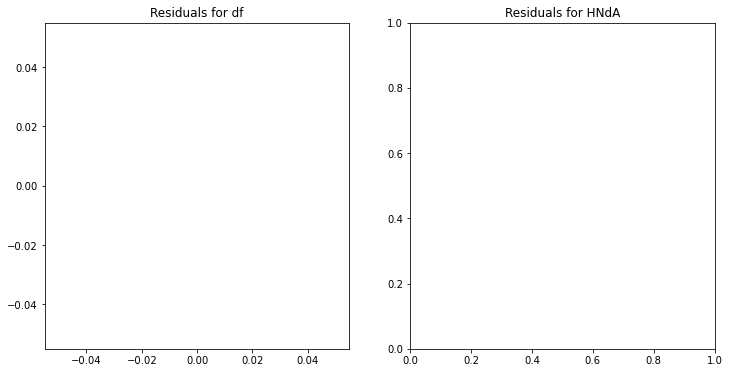

In [7]:
'''
Plot of the residual data
'''
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))


ax[0].plot(iteration_list, df_list_max)
ax[0].plot(iteration_list, df_list_min)

#ax[1].plot(iteration_list, dHNdA_list_max)
#ax[1].plot(iteration_list, dHNdA_list_min)



ax[0].set_title('Residuals for df')
ax[1].set_title('Residuals for HNdA')

In [8]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

# Volume calculating Flo

In [26]:
V = 0
for v in HC.V:
    V_ijk = volume(v)
    #print(V_ijk)
    V += np.sum(V_ijk)

V = V/12

In [27]:
V

0.7459468368823017

In [30]:
def fun_V_analytic(r, v_l, v_u):
    V_an = np.pi/4*r**2*(v_u-v_l)
    return V_an

In [31]:
fun_V_analytic(1,-0.5,0.5)

0.7853981633974483

# Save and load from complexes

In [12]:
'''
Save and load don't work --> ask Stefan
'''
#HC.save_complex(fn='data.json')

"\nSave and load don't work --> ask Stefan\n"